# Técnicas de NLP para preprocesamiento de textos y análisis de Sentimientos en Tweets

Marcos Dayan Mann

A01782876

## Importación de todas las librerías que necesitamos
Tanto de preprocesamiento como NLTK, como algunos modelos de SKlearn para validar nuestro preprocesamiento


In [33]:
import pandas as pd
import numpy as np
import re
import emoji
from collections import Counter, defaultdict

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

# nltk
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, FreqDist
from nltk.corpus import sentiwordnet as swn

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### Descarga de Recursos NLTK

Es necesario descargar los recursos de NLTK para realizar tokenización, lematización, análisis de sentimientos y etiquetado POS.

In [34]:
download_list = [
    'punkt',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'omw-1.4',
    'sentiwordnet',
    'vader_lexicon'
]
    
for item in download_list:
    try:
        nltk.download(item, quiet=True)
    except:
        print(f"No se pudo descargar {item}")

print("Recursos NLTK descargados correctamente")

Recursos NLTK descargados correctamente


## 1. Pipeline de Preprocesamiento de Texto

En esta sección se diseñé un pipeline completo de preprocesamiento para sacarle el mayor provecho al significado del vocabulario, eliminar el ruido, links, emojis, y cosas que hacen el texto menos procesable y más ambiguo, esto con diferentes herramientas como procesamiento con nltk, expresiones regulares, lematización, entre otras herramientas que vimos en clase.

Proceso del pipeline:

1. Manejo de caracteres especiales y emojis (codificación utf-8)
2. Reducción de vocabulario redundante y pasar el texto a minúsculas
3. Extracción y limpieza estructurada de URLs, menciones, hashtags, todo ésto con regex
4. Eliminación de stopwords para hacer menos ambiguos los textos
5. Parsear emojis por palabras clave, agarré emojis comunes que expresan sentimientos positivos y negativos, para tratar de sacar un poco m+as de contexto de los emojis
6. Identificación de categorías gramaticales para lematización contextual con Pos Tagging
7. Lematización y stemming a los textos 

### Carga de Datos

Cargamos los archivos de entrenamiento y prueba, manteniendo el formato original con headers. Los datos contienen tweets etiquetados con diferentes categorías de sentimiento.

In [43]:
# cargar datos
train_df = pd.read_csv('originallTraining.txt', sep='\t', header=None, 
                       names=['tweet_id', 'user_id', 'sentiment', 'text'])
test_df = pd.read_csv('originalTest.txt', sep='\t', header=None,
                      names=['tweet_id', 'user_id', 'sentiment', 'text'])

print(f"Datos de entrenamiento: {train_df.shape[0]} tweets")
print(f"Datos de prueba: {test_df.shape[0]} tweets")
print(f"\nCategorías de sentimiento en entrenamiento:")
print(train_df['sentiment'].value_counts())
print(f"\nPrimeros 3 ejemplos:")
train_df.head(3)

Datos de entrenamiento: 6152 tweets
Datos de prueba: 974 tweets

Categorías de sentimiento en entrenamiento:
sentiment
positive                2248
objective-OR-neutral    1106
neutral                 1079
objective                863
negative                 856
Name: count, dtype: int64

Primeros 3 ejemplos:


,tweet_id,user_id,sentiment,text
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
2,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...


In [51]:
# decidí englobar el pipeline en una clase para que sea más fácil aplicarlo muchas veces, para training y testing, solo creando una instancia de la clase y llamando al método "preprocess()"
class TextPreprocessor:
    """
    Pipeline completo de preprocesamiento de texto para análisis de sentimientos.
    """
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        
        # Stopwords de nltk
        self.stop_words = set(stopwords.words('english'))
        # Dejar palabras que indican sentimiento (como lo que vimos en clase, como son tweets, de por si no tienen mucho contexto, entonces dejamos algunas stopwords)
        sentiment_words = {'not', 'no', 'nor', 'never', 'neither', 'nobody', 
                          'none', 'nothing', 'very', 'too', 'so', 'more', 'most'}
        self.stop_words = self.stop_words - sentiment_words
        
        print("TextPreprocessor inicializado")
    
    def decode_text_utf8(self, text):
        """decodificación en utf-8"""
        if isinstance(text, bytes):
            return text.decode('utf-8', errors='ignore')
        return str(text)
    
    def extract_features(self, text):
        """extracción de características especiales"""
        features = {
            'urls': re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text),
            'mentions': re.findall(r'@\w+', text),
            'hashtags': re.findall(r'#\w+', text),
            'emojis': [char for char in text if char in emoji.EMOJI_DATA]
        }
        return features

    def clean_with_regex(self, text):
        """Limpieza con patrones Regex"""
        # Reemplazar URLs con token especial
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' URL ', text)
        
        # contenido de hashtags djando la palabra
        text = re.sub(r'#(\w+)', r'\1', text)
        #  menciones de redes sociales
        text = re.sub(r'@\w+', '', text)
        
        # números
        text = re.sub(r'\d+', ' NUM ', text)
        # Remover caracteres repetidos tipo holaaaa -> hola
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        
        return text
    
    def handle_case(self, text):
        """todo a minúsculas"""
        # Convertir a minúsculas para normalizar
        return text.lower()
    
    def handle_punctuation(self, text, preserve_sentiment=True):
        """quitar puntuación y manejar signos de exclamación e interrogación"""
        if preserve_sentiment:
            text = text.replace('!', ' EXCLAMATION ')
            text = text.replace('?', ' QUESTION ')
        
        # Remover otra puntuación
        text = re.sub(r'[^\w\s]', ' ', text)
        
        return text
    
    def tokenize(self, text):
        """tokenización"""
        # primero sentence y luego word como vimos en clase, ayuda a que se separen mejor los tokens
        sentence_tokens = sent_tokenize(text)
        tokens = [word_tokenize(sentence) for sentence in sentence_tokens]
        return tokens
    
    def remove_stopwords(self, tokens):
        """remover stopwords"""
        if len(tokens) == 1:
            tokens = tokens[0]
        return [token for token in tokens if token not in self.stop_words]
    
    def get_wordnet_pos(self, treebank_tag):
        """PoS tags"""
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    def lemmatize_with_pos(self, tokens):
        """lematización con POS tagging"""
        # Obtener POS tags
        pos_tags = pos_tag(tokens)
        
        # Lematizar según el POS tag
        lemmatized = []
        for token, tag in pos_tags:
            wordnet_pos = self.get_wordnet_pos(tag)
            lemmatized.append(self.lemmatizer.lemmatize(token, pos=wordnet_pos))
        
        return lemmatized
    
    def stem_tokens(self, tokens):
        """stemming"""
        return [self.stemmer.stem(token) for token in tokens]
    
    def preprocess(self, text, use_stemming=False):
        """preprocesamiento completo en pipeline"""
        text = self.decode_text_utf8(text)
        features = self.extract_features(text) # para analizar, no se usan para el preprocesamiento
        text = self.clean_with_regex(text)
        text = self.handle_case(text)
        text = self.handle_punctuation(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        # o stemming o lematización, se va a probar con cada una
        if use_stemming:
            tokens = self.stem_tokens(tokens)
        else:
            tokens = self.lemmatize_with_pos(tokens)
        # tokens = [token for token in tokens if len(token) > 2]
        
        return ' '.join(tokens), features


preprocessor = TextPreprocessor()

TextPreprocessor inicializado


### Demostración del Pipeline

Probamos el pipeline con ejemplos reales del dataset para verificar su funcionamiento.

In [52]:
# Ejemplos de preprocesamiento
print("proeba del pipeline de preprocesamiento")

for i in range(3):
    original = train_df.iloc[i]['text']
    processed, features = preprocessor.preprocess(original)
    
    print(f"Ejemplo {i+1}:")
    print(f"Sentimiento: {train_df.iloc[i]['sentiment']}")
    print(f"Original:\n{original}")
    print(f"Procesado:\n{processed}")
    print(f"Características extraídas:")
    for key, value in features.items():
        if value:
            print(f"  - {key}: {value}")
    print()

proeba del pipeline de preprocesamiento
Ejemplo 1:
Sentimiento: positive
Original:
Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
Procesado:
gas house hit num num EXCLAMATION EXCLAMATION go chapel hill sit
Características extraídas:

Ejemplo 2:
Sentimiento: negative
Original:
Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
Procesado:
iranian general say israel iron dome deal missile keep talk like may end find
Características extraídas:

Ejemplo 3:
Sentimiento: positive
Original:
with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
Procesado:
j davlar num th main rival team poland hopefully make successful end tough week training tomorrow
Características extraídas:



### Aplicación del Pipeline a Todo el Dataset

Aplicamos el preprocesamiento a todos los tweets de entrenamiento y prueba.

In [54]:
# Aplicar preprocesamiento a todo el dataset
print("Preprocesando datos de entrenamiento...")
train_df['processed_text'] = train_df['text'].apply(lambda x: preprocessor.preprocess(x)[0])

print("Preprocesando datos de prueba...")
test_df['processed_text'] = test_df['text'].apply(lambda x: preprocessor.preprocess(x)[0])

# Simplificar etiquetas de sentimiento
# def simplify_sentiment(sentiment):
#     """Simplifica las categorías de sentimiento"""
#     sentiment = sentiment.lower().strip()
#     if 'positive' in sentiment:
#         return 'positive'
#     elif 'negative' in sentiment:
#         return 'negative'
#     elif 'neutral' in sentiment:
#         return 'neutral'
#     else:
#         return 'objective'

# train_df['sentiment_simple'] = train_df['sentiment'].apply(simplify_sentiment)
# test_df['sentiment_simple'] = test_df['sentiment'].apply(simplify_sentiment)

train_df['sentiment_simple'] = train_df['sentiment']
test_df['sentiment_simple'] = test_df['sentiment']

print(f"\nPreprocesamiento completado")
print(f"Distribución de sentimientos (simplificada):")
print(train_df['sentiment_simple'].value_counts())
train_df[['text', 'processed_text', 'sentiment_simple']].head()

Preprocesando datos de entrenamiento...
Preprocesando datos de prueba...

Preprocesamiento completado
Distribución de sentimientos (simplificada):
sentiment_simple
positive                2248
objective-OR-neutral    1106
neutral                 1079
objective                863
negative                 856
Name: count, dtype: int64


,text,processed_text,sentiment_simple
0,Gas by my house hit $3.39!!!! I'm going to Cha...,gas house hit num num EXCLAMATION EXCLAMATION ...,positive
1,Iranian general says Israel's Iron Dome can't ...,iranian general say israel iron dome deal miss...,negative
2,with J Davlar 11th. Main rivals are team Polan...,j davlar num th main rival team poland hopeful...,positive
3,"Talking about ACT's && SAT's, deciding where I...",talk act sat decide want go college apply coll...,negative
4,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dallas dallas win superbowl not ...,negative


## 2. Visualizaciones del Vocabulario (10 Visualizaciones)

En esta sección exploramos la riqueza y distribución del vocabulario mediante 10 visualizaciones distintas, incluyendo la verificación de la Ley de Zipf.

### Preparación: Análisis de Frecuencias

In [65]:
# Análisis de frecuencias de palabras
all_words = []
for text in train_df['processed_text']:
    all_words.extend(text.split())

# Frecuencias
word_freq = FreqDist(all_words)
vocab_size = len(word_freq)
total_words = len(all_words)

print(f"Estadísticas del Vocabulario:")
print(f"   - Vocabulario único: {vocab_size:,} palabras")
print(f"   - Total de palabras: {total_words:,}")
print(f"   - Riqueza léxica: {vocab_size/total_words:.4f}")
print(f"\nPalabras más comunes:")
for word, freq in word_freq.most_common(15):
    print(f"   {word:20} : {freq:5,} veces")

Estadísticas del Vocabulario:
   - Vocabulario único: 11,807 palabras
   - Total de palabras: 83,122
   - Riqueza léxica: 0.1420

Palabras más comunes:
   num                  : 5,383 veces
   EXCLAMATION          : 2,960 veces
   url                  : 1,696 veces
   tomorrow             : 1,039 veces
   QUESTION             :   768 veces
   go                   :   765 veces
   th                   :   764 veces
   day                  :   665 veces
   night                :   611 veces
   get                  :   537 veces
   may                  :   503 veces
   tonight              :   481 veces
   see                  :   442 veces
   st                   :   405 veces
   time                 :   396 veces


### Visualización 1: Ley de Zipf (Log-Log Plot)

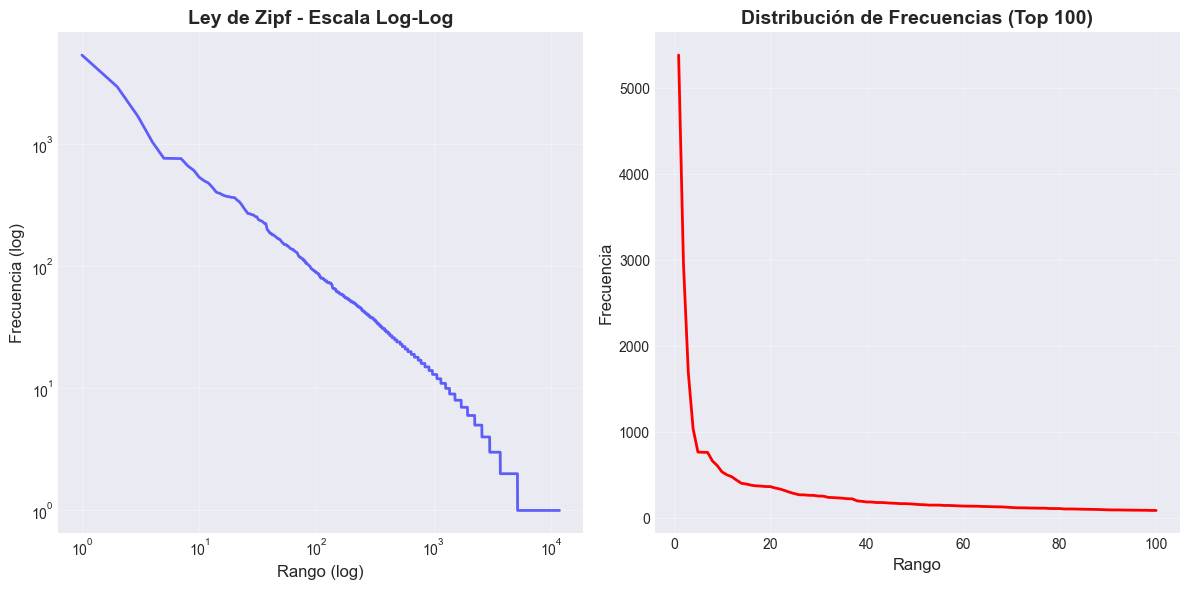

La línea recta en escala log-log confirma la Ley de Zipf


In [66]:
# Visualización 1: Ley de Zipf
ranks = np.arange(1, len(word_freq) + 1)
frequencies = sorted([freq for word, freq in word_freq.items()], reverse=True)

plt.figure(figsize=(12, 6))

# Log-Log plot
plt.subplot(1, 2, 1)
plt.loglog(ranks, frequencies, 'b-', alpha=0.6, linewidth=2)
plt.xlabel('Rango (log)', fontsize=12)
plt.ylabel('Frecuencia (log)', fontsize=12)
plt.title('Ley de Zipf - Escala Log-Log', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Linear plot (primeras 100 palabras)
plt.subplot(1, 2, 2)
plt.plot(ranks[:100], frequencies[:100], 'r-', linewidth=2)
plt.xlabel('Rango', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Frecuencias (Top 100)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("La línea recta en escala log-log confirma la Ley de Zipf")

### Visualización 2: Nube de Palabras (WordCloud)

Visualización intuitiva de las palabras más frecuentes según cada categoría de sentimiento.

Se puede ver que en nuestro dataset, los signos de puntuación son muy repetidos entre cada una de las categorías, lo que puede hacer que para el modelo sea muy ambiguo basarse en este token para clasificar. Por esto probablemente será bueno hacer limpieza de estos signos en la parte de enriquecimiento de texto, porque no aportan mucho

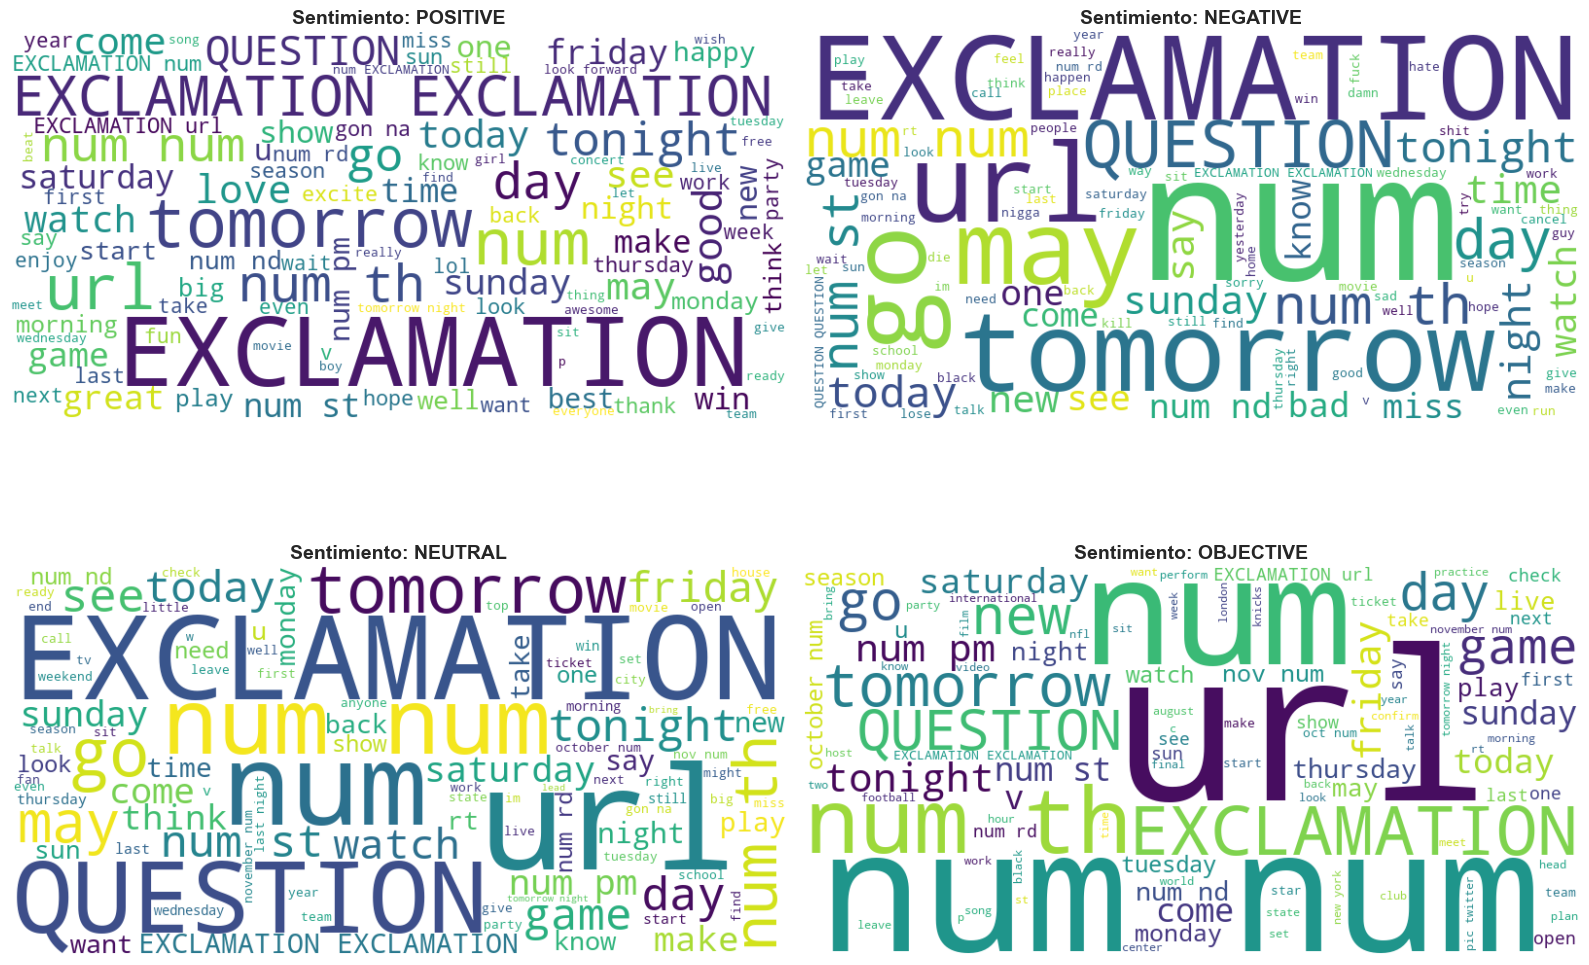

WordClouds generadas para cada categoría de sentimiento


In [67]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sentiments = ['positive', 'negative', 'neutral', 'objective']

for idx, sentiment in enumerate(sentiments):
    ax = axes[idx // 2, idx % 2]
    
    # Obtener texto de este sentimiento
    text = ' '.join(train_df[train_df['sentiment_simple'] == sentiment]['processed_text'])
    
    if text.strip():  # Solo si hay texto
        wordcloud = WordCloud(width=800, height=400, 
                            background_color='white',
                            colormap='viridis',
                            max_words=100).generate(text)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Sentimiento: {sentiment.upper()}', fontsize=14, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

print("WordClouds generadas para cada categoría de sentimiento")

### Visualización 3: Top 20 Palabras Más Frecuentes (Bar Chart)

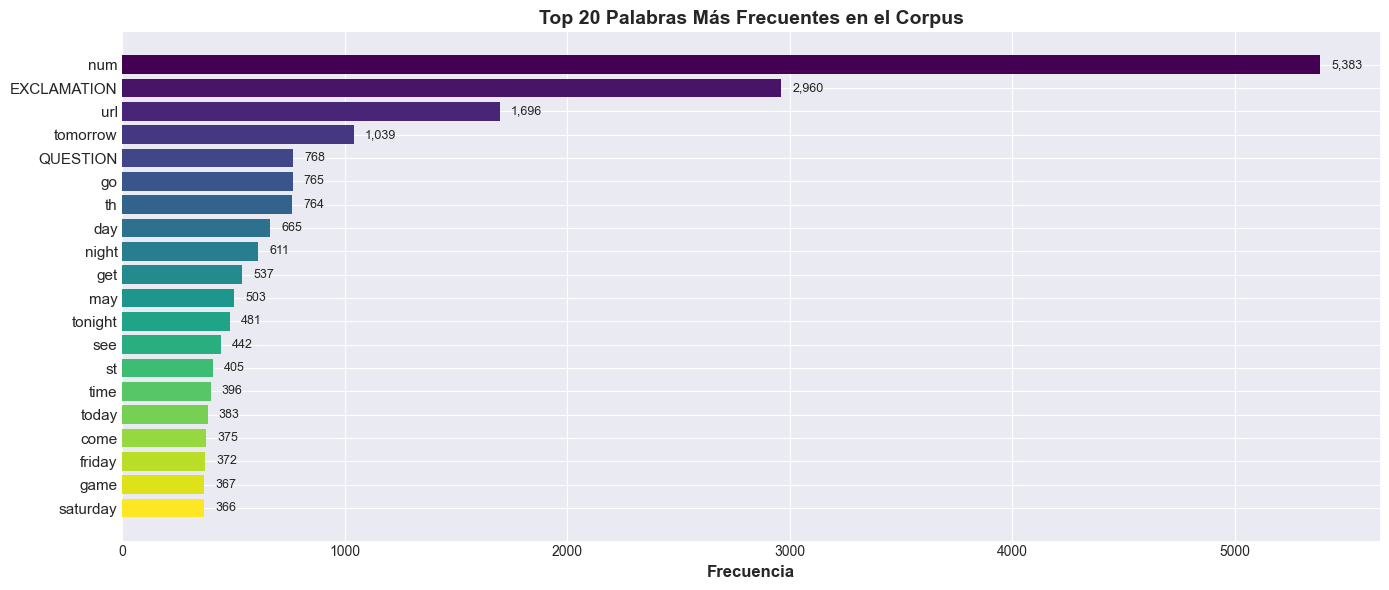

In [68]:
top_20 = word_freq.most_common(20)
words, freqs = zip(*top_20)

plt.figure(figsize=(14, 6))
bars = plt.barh(range(len(words)), freqs, color=plt.cm.viridis(np.linspace(0, 1, len(words))))
plt.yticks(range(len(words)), words, fontsize=11)
plt.xlabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Top 20 Palabras Más Frecuentes en el Corpus', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Agregar valores en las barras
for i, (word, freq) in enumerate(top_20):
    plt.text(freq + 50, i, f'{freq:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Visualización 4: Distribución de Longitud de Tweets

Acá se puede ver que las longitudes de los tweets son muy chicas, lo que dificulta mucho el análisis de sentimientos, porque esto va sumaod a que no se usa gran variedad de lenguaje en los tweets

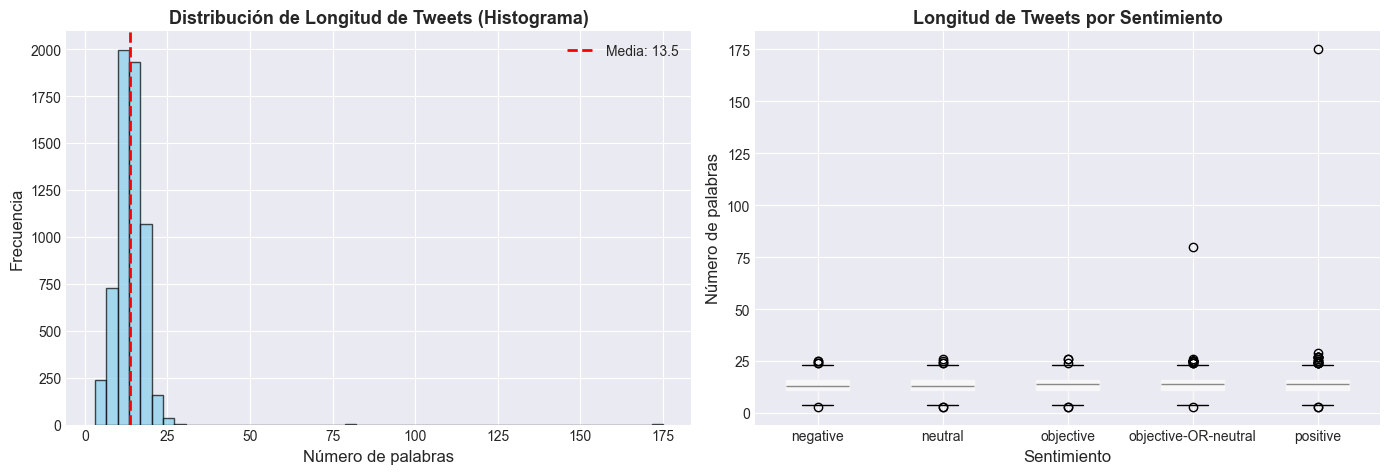

Estadísticas de longitud:
                       count       mean       std  min   25%   50%   75%  \
sentiment_simple                                                           
negative               856.0  13.185748  3.691854  3.0  11.0  13.0  16.0   
neutral               1079.0  13.171455  3.814736  3.0  11.0  13.0  16.0   
objective              863.0  13.667439  3.874115  3.0  11.0  14.0  16.0   
objective-OR-neutral  1106.0  13.673599  4.389124  3.0  11.0  14.0  16.0   
positive              2248.0  13.658808  5.096545  3.0  11.0  14.0  16.0   

                        max  
sentiment_simple             
negative               25.0  
neutral                26.0  
objective              26.0  
objective-OR-neutral   80.0  
positive              175.0  


In [69]:
train_df['text_length'] = train_df['processed_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Número de palabras', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Longitud de Tweets (Histograma)', fontsize=13, fontweight='bold')
plt.axvline(train_df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {train_df["text_length"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
train_df.boxplot(column='text_length', by='sentiment_simple', ax=plt.gca(), patch_artist=True)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Número de palabras', fontsize=12)
plt.title('Longitud de Tweets por Sentimiento', fontsize=13, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"Estadísticas de longitud:")
print(train_df.groupby('sentiment_simple')['text_length'].describe())

### Visualización 5: Frecuencia Acumulada de Vocabulario

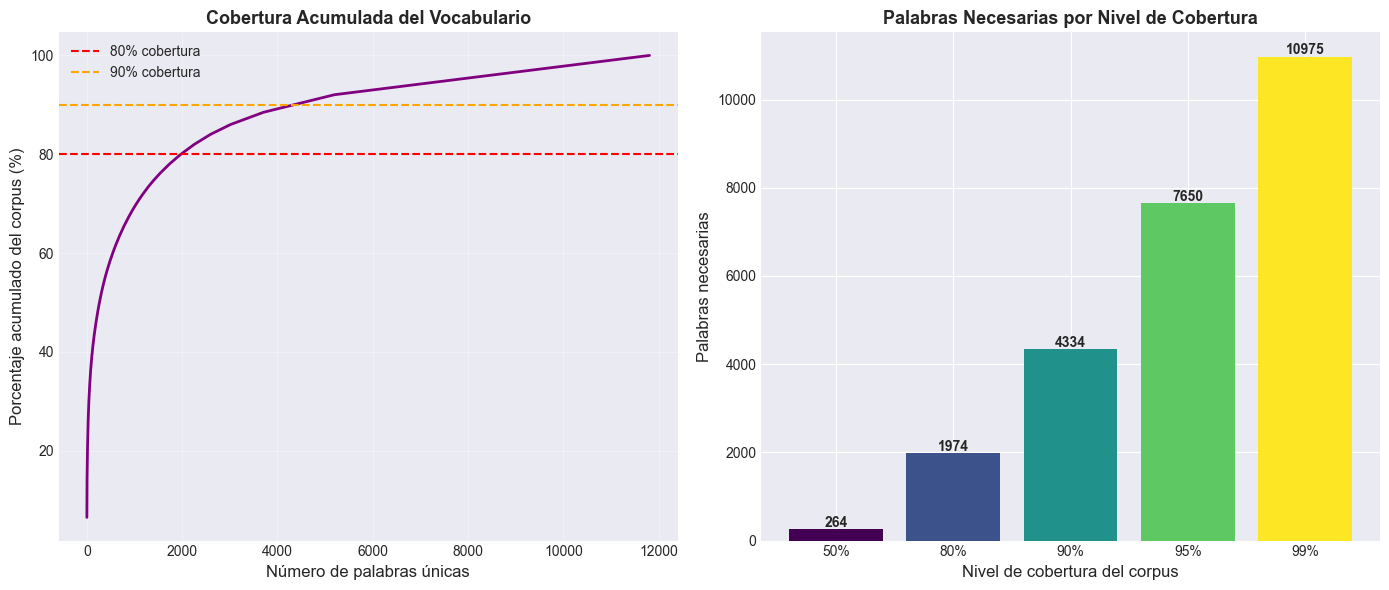

Para cubrir el 80% del corpus necesitamos: 1,974 palabras


In [70]:
sorted_freqs = sorted(word_freq.values(), reverse=True)
cumsum_freqs = np.cumsum(sorted_freqs)
cumsum_percent = (cumsum_freqs / cumsum_freqs[-1]) * 100

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumsum_percent, linewidth=2, color='purple')
plt.xlabel('Número de palabras únicas', fontsize=12)
plt.ylabel('Porcentaje acumulado del corpus (%)', fontsize=12)
plt.title('Cobertura Acumulada del Vocabulario', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=80, color='r', linestyle='--', label='80% cobertura')
plt.axhline(y=90, color='orange', linestyle='--', label='90% cobertura')
plt.legend()

plt.subplot(1, 2, 2)
# Mostrar cuántas palabras necesitamos para cubrir X% del corpus
coverage_levels = [50, 80, 90, 95, 99]
words_needed = []
for level in coverage_levels:
    idx = np.argmax(cumsum_percent >= level)
    words_needed.append(idx)
    
plt.bar(range(len(coverage_levels)), words_needed, color=plt.cm.viridis(np.linspace(0, 1, len(coverage_levels))))
plt.xticks(range(len(coverage_levels)), [f'{level}%' for level in coverage_levels])
plt.xlabel('Nivel de cobertura del corpus', fontsize=12)
plt.ylabel('Palabras necesarias', fontsize=12)
plt.title('Palabras Necesarias por Nivel de Cobertura', fontsize=13, fontweight='bold')

for i, v in enumerate(words_needed):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Para cubrir el 80% del corpus necesitamos: {words_needed[1]:,} palabras")

### Visualizaciones 6-10: Análisis Adicionales del Vocabulario

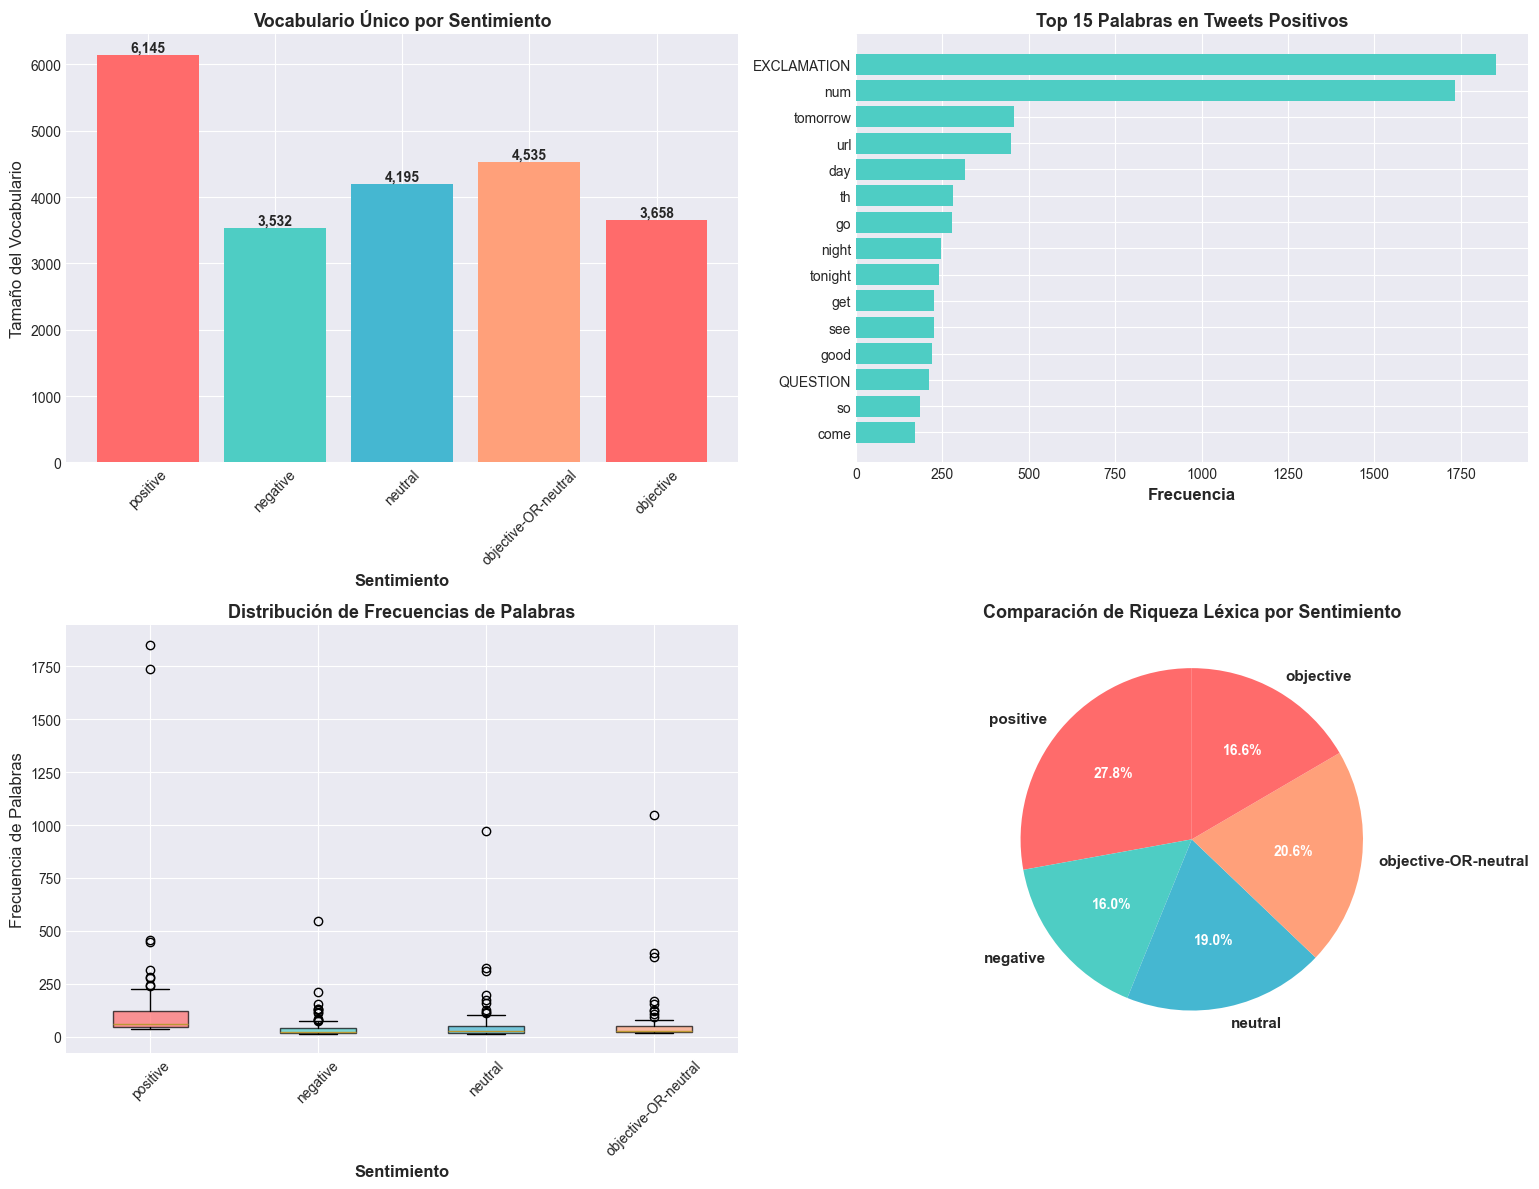


Análisis de Vocabulario por Sentimiento:
------------------------------------------------------------
Positive     - 6,145 palabras únicas
Negative     - 3,532 palabras únicas
Neutral      - 4,195 palabras únicas
Objective-or-neutral - 4,535 palabras únicas
Objective    - 3,658 palabras únicas

Compartido   -   996 palabras comunes a todos
Visualizaciones 6-10 completadas


In [71]:
# Visualización 6: Vocabulario único por sentimiento
vocab_by_sentiment = {}
for sentiment in train_df['sentiment_simple'].unique():
    words = set()
    for text in train_df[train_df['sentiment_simple'] == sentiment]['processed_text']:
        words.update(text.split())
    vocab_by_sentiment[sentiment] = words

sentiments = list(vocab_by_sentiment.keys())
vocab_sizes = [len(vocab_by_sentiment[s]) for s in sentiments]

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 6: Tamaño de vocabulario por sentimiento
ax1 = axes[0, 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax1.bar(sentiments, vocab_sizes, color=colors)
ax1.set_xlabel('Sentimiento', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tamaño del Vocabulario', fontsize=12)
ax1.set_title('Vocabulario Único por Sentimiento', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
# Agregar valores en las barras
for bar, size in zip(bars, vocab_sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 7: Top 15 palabras por sentimiento (ejemplo: positive)
ax2 = axes[0, 1]
positive_words = []
for text in train_df[train_df['sentiment_simple'] == 'positive']['processed_text']:
    positive_words.extend(text.split())
pos_freq = Counter(positive_words).most_common(15)
words_p, freqs_p = zip(*pos_freq)

ax2.barh(range(len(words_p)), freqs_p, color='#4ECDC4')
ax2.set_yticks(range(len(words_p)))
ax2.set_yticklabels(words_p, fontsize=10)
ax2.set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 Palabras en Tweets Positivos', fontsize=13, fontweight='bold')
ax2.invert_yaxis()

# Gráfico 8: Distribución de frecuencias por sentimiento (box plot)
ax3 = axes[1, 0]
freq_data = []
labels = []
for sentiment in sentiments[:4]:  # Primeros 4 sentimientos
    words_sent = []
    for text in train_df[train_df['sentiment_simple'] == sentiment]['processed_text']:
        words_sent.extend(text.split())
    freq_sent = Counter(words_sent)
    # Tomar solo top 100 frecuencias para visualización
    freq_data.append(sorted(list(freq_sent.values()), reverse=True)[:100])
    labels.append(sentiment)

bp = ax3.boxplot(freq_data, labels=labels, patch_artist=True)
# Colorear las cajas
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xlabel('Sentimiento', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frecuencia de Palabras', fontsize=12)
ax3.set_title('Distribución de Frecuencias de Palabras', fontsize=13, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Gráfico 9 y 10: Pie chart de vocabulario
ax4 = axes[1, 1]
wedges, texts, autotexts = ax4.pie(vocab_sizes, labels=sentiments, autopct='%1.1f%%',
                                     colors=colors, startangle=90)
# Mejorar el estilo del texto
for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
ax4.set_title('Comparación de Riqueza Léxica por Sentimiento', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis adicional de vocabulario compartido
print("\nAnálisis de Vocabulario por Sentimiento:")
print("-" * 60)
for sentiment, vocab in vocab_by_sentiment.items():
    print(f"{sentiment.capitalize():12} - {len(vocab):5,} palabras únicas")

# Vocabulario compartido entre todos los sentimientos
shared_vocab = set.intersection(*[vocab_by_sentiment[s] for s in sentiments])
print(f"\n{'Compartido':12} - {len(shared_vocab):5,} palabras comunes a todos")

print("Visualizaciones 6-10 completadas")

## 3. Enriquecimiento con Taxonomías Léxicas

En esta sección implementé el uso de recursos léxicos especializados para mejorar la representación semántica y de sentimientos.

### Fundamento Teórico

Las taxonomías léxicas como **WordNet**, **SentiWordNet** y **EmoLex** proporcionan información semántica rica que puede mejorar significativamente el análisis de sentimientos:

- **WordNet**: Jerarquía de synsets (conjuntos de sinónimos)
- **SentiWordNet**: Scores de positividad, negatividad y objetividad
- **Emojis**: Conversión a texto con carga emocional

In [73]:
# igual hice una clase para el enriquecimiento de taxonomías para poder aplicar el flujo de forma fácil
class SentimentEnricher:
    """
    Clase para enriquecer el texto con información de taxonomías léxicas.
    Implementa WordNet, SentiWordNet y manejo de emojis.
    """
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        # Mapeo manual de emojis comunes a sentimientos
        self.emoji_sentiment = {
            '😊': 'happy', '😃': 'very_happy', '😄': 'joyful',
            '😢': 'sad', '😭': 'very_sad', '😞': 'disappointed',
            '😠': 'angry', '😡': 'very_angry', '🤬': 'furious',
            '❤️': 'love', '💕': 'affection', '💔': 'heartbreak',
            '👍': 'approval', '👎': 'disapproval',
            '😍': 'adoration', '🤗': 'warm',
            '😂': 'laughing', '🤣': 'hilarious'
        }
        print("SentimentEnricher inicializado")
    
    def get_wordnet_pos(self, treebank_tag):
        """Convertir POS tag a formato WordNet"""
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    def get_sentiment_score(self, word, pos=wordnet.NOUN):
        """Obtener score de sentimiento de SentiWordNet"""
        try:
            synsets = list(swn.senti_synsets(word, pos))
            if synsets:
                # Promedio de scores
                pos_score = np.mean([s.pos_score() for s in synsets])
                neg_score = np.mean([s.neg_score() for s in synsets])
                obj_score = np.mean([s.obj_score() for s in synsets])
                return {
                    'positive': pos_score,
                    'negative': neg_score,
                    'objective': obj_score,
                    'sentiment': pos_score - neg_score  # Score neto
                }
        except:
            pass
        return {'positive': 0, 'negative': 0, 'objective': 1, 'sentiment': 0}
    
    def process_emojis(self, text):
        """Convertir emojis a representación textual con sentimiento"""
        for emoji_char, sentiment_word in self.emoji_sentiment.items():
            if emoji_char in text:
                text = text.replace(emoji_char, f' EMOJI_{sentiment_word} ')
        
        # Convertir otros emojis a texto descriptivo
        text = emoji.demojize(text, delimiters=(" EMOJI_", " "))
        return text
    
    def get_synonyms(self, word, pos=wordnet.NOUN):
        """Obtener sinónimos de WordNet"""
        synonyms = set()
        try:
            for syn in wordnet.synsets(word, pos=pos):
                for lemma in syn.lemmas():
                    synonyms.add(lemma.name().replace('_', ' '))
        except:
            pass
        return list(synonyms)[:3]  # Limitar a 3 sinónimos
    
    def enrich_text(self, text, add_synonyms=False, add_sentiment_scores=True):
        """Enriquecer texto con información léxica"""
        # Procesar emojis primero
        text = self.process_emojis(text)
        
        # Tokenizar y POS tagging
        tokens = word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        
        enriched_tokens = []
        sentiment_features = []
        
        for token, tag in pos_tags:
            if len(token) > 2:
                # Agregar token original
                enriched_tokens.append(token)
                
                # Lematizar
                wordnet_pos = self.get_wordnet_pos(tag)
                lemma = self.lemmatizer.lemmatize(token, pos=wordnet_pos)
                
                # Obtener sentiment score
                if add_sentiment_scores:
                    sent_score = self.get_sentiment_score(lemma, wordnet_pos)
                    sentiment_features.append(sent_score['sentiment'])
                    
                    # Si la palabra tiene sentimiento fuerte, agregar indicador
                    if abs(sent_score['sentiment']) > 0.3:
                        if sent_score['sentiment'] > 0:
                            enriched_tokens.append('SENTIMENT_POSITIVE')
                        else:
                            enriched_tokens.append('SENTIMENT_NEGATIVE')
                
                # Agregar sinónimos si se requiere
                if add_synonyms and wordnet_pos in [wordnet.ADJ, wordnet.VERB]:
                    synonyms = self.get_synonyms(lemma, wordnet_pos)
                    if synonyms:
                        enriched_tokens.extend(synonyms[:1])  # Solo 1 sinónimo
        
        avg_sentiment = np.mean(sentiment_features) if sentiment_features else 0
        
        return {
            'enriched_text': ' '.join(enriched_tokens),
            'avg_sentiment_score': avg_sentiment,
            'sentiment_features': sentiment_features
        }

# Inicializar enricher
enricher = SentimentEnricher()

SentimentEnricher inicializado


### Prueba usando el flujo de Enriquecimiento Léxico

In [74]:
print("Prueba usando el flujo de Enriquecimiento Léxico")

for i in [0, 10, 20]:
    original = train_df.iloc[i]['text']
    processed = train_df.iloc[i]['processed_text']
    enriched = enricher.enrich_text(original)
    
    print(f"Ejemplo {i+1}:")
    print(f"Sentimiento real: {train_df.iloc[i]['sentiment_simple']}")
    print(f"Original:\n{original}")
    print(f"Procesado básico:\n{processed}")
    print(f"Enriquecido:\n{enriched['enriched_text']}")
    print(f"Score promedio de sentimiento: {enriched['avg_sentiment_score']:.3f}")
    print()

Prueba usando el flujo de Enriquecimiento Léxico
Ejemplo 1:
Sentimiento real: positive
Original:
Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
Procesado básico:
gas house hit num num EXCLAMATION EXCLAMATION go chapel hill sit
Enriquecido:
gas house hit 3.39 going chapel hill sat
Score promedio de sentimiento: -0.005

Ejemplo 11:
Sentimiento real: positive
Original:
One ticket left for the @49ers game tomorrow! Don't miss the rematch of the NFC Championship game against the NY Giants! Hit me up!
Procesado básico:
one ticket leave game tomorrow EXCLAMATION miss rematch nfc championship game ny giant EXCLAMATION hit EXCLAMATION
Enriquecido:
one ticket left for the 49ers game tomorrow n't miss the rematch the nfc championship game against the giants hit
Score promedio de sentimiento: -0.016

Ejemplo 21:
Sentimiento real: objective-OR-neutral
Original:
@TooZany is bringing out Kendrick Lamar the 6th of December!?! Get your tickets now!
Procesado básico:
bring kendrick la

## 4. Experimentos de Clasificación de Sentimientos

En esta sección implementé y evalué 20 variaciones experimentales distintas combinando diferentes:
- Técnicas de preprocesamiento
- Representaciones vectoriales
- Algoritmos de aprendizaje supervisado
- Configuraciones de hiperparámetros

### Preparación de Datos

In [82]:
# Preparar datos para clasificación binaria y multi-clase
# Simplificamos a 3 clases principales: positive, negative, neutral/objective
def merge_sentiments(df):
    """Combinar objective con neutral para balance"""
    df_copy = df.copy()
    df_copy['sentiment_merged'] = df_copy['sentiment_simple'].replace('objective', 'neutral')
    return df_copy

sentiment = 'sentiment_simple'

train_df_merged = merge_sentiments(train_df)
test_df_merged = merge_sentiments(test_df)

train_df = train_df_merged
test_df = test_df_merged
sentiment = 'sentiment_merged'

print("Distribución de clases (merged):")
print(train_df['sentiment_merged'].value_counts())

# Preparar diferentes versiones del texto
print("\nGenerando diferentes versiones de preprocesamiento...")

# Versión 1: Texto básico preprocesado
X_train_basic = train_df['processed_text']
X_test_basic = test_df['processed_text']

# Versión 2: Texto con stemming
X_train_stem = train_df['text'].apply(lambda x: preprocessor.preprocess(x, use_stemming=True)[0])
X_test_stem = test_df['text'].apply(lambda x: preprocessor.preprocess(x, use_stemming=True)[0])

# Versión 3: Texto enriquecido
print("Enriqueciendo textos (se tarda un poco)...")
X_train_enriched = train_df['text'].apply(lambda x: enricher.enrich_text(x)['enriched_text'])
X_test_enriched = test_df['text'].apply(lambda x: enricher.enrich_text(x)['enriched_text'])

# Labels
y_train = train_df[sentiment]
y_test = test_df[sentiment]

print(f"\nPreparación completada")
print(f"   Training samples: {len(X_train_basic)}")
print(f"   Test samples: {len(X_test_basic)}")
print(f"   Classes: {y_train.unique()}")

Distribución de clases (merged):
sentiment_merged
positive                2248
neutral                 1942
objective-OR-neutral    1106
negative                 856
Name: count, dtype: int64

Generando diferentes versiones de preprocesamiento...
Enriqueciendo textos (se tarda un poco)...
Enriqueciendo textos (se tarda un poco)...

Preparación completada
   Training samples: 6152
   Test samples: 974
   Classes: ['positive' 'negative' 'neutral' 'objective-OR-neutral']

Preparación completada
   Training samples: 6152
   Test samples: 974
   Classes: ['positive' 'negative' 'neutral' 'objective-OR-neutral']


### Definición de los 20 Experimentos

**Justificación de las Variaciones:**

Cada experimento combina diferentes elementos del pipeline de NLP para evaluar su impacto:

1. Representaciones Vectoriales:
   - Bag of Words (BoW)
   - One Hot encoding
   
2. Algoritmos de Aprendizaje:
   - Naive Bayes (Multinomial, Bernoulli)
   - Logistic Regression
   - SVM
   - Random Forest
   - Gradient Boosting
   
3. Preprocesamiento:
   - Lematización
   - Stemming
   - Enriquecimiento léxico
   
4. Configuraciones Adicionales:
   - Diferentes hiperparámetros
   - Balanceo de clases
   - Combinaciones híbridas

In [83]:
# igual una clase para orquestrar cada experimento
class ExperimentManager:
    """Gestor de experimentos de clasificación"""
    
    def __init__(self):
        self.results = []
    
    def run_experiment(self, exp_num, name, vectorizer, classifier, X_train, X_test, y_train, y_test, description):
        """Ejecutar un experimento completo"""
        print(f"\nExperimento {exp_num}: {name}")
        print(f"   {description}")
        
        # Vectorizar
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        # Entrenar
        classifier.fit(X_train_vec, y_train)
        
        # Predecir
        y_pred = classifier.predict(X_test_vec)
        
        # Evaluar
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Guardar resultados
        result = {
            'experiment': exp_num,
            'name': name,
            'description': description,
            'accuracy': accuracy,
            'f1_score': f1,
            'vectorizer': type(vectorizer).__name__,
            'classifier': type(classifier).__name__
        }
        self.results.append(result)
        
        print(f"   Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}")
        
        return result
    
    def get_results_df(self):
        """Retornar resultados como DataFrame"""
        return pd.DataFrame(self.results)

# Inicializar gestor de experimentos
exp_manager = ExperimentManager()

### Ejecución de los 20 Experimentos

In [88]:
print("Ejecutando los 20 experimentos de clasificación")

# EXPERIMENTO 1: Baseline - BoW + Naive Bayes
exp_manager.run_experiment(
    1, "Baseline: BoW + Naive Bayes",
    CountVectorizer(max_features=5000),
    MultinomialNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Configuración básica con Bag of Words y Naive Bayes Multinomial"
)

# EXPERIMENTO 2: BoW (más features) + Naive Bayes
exp_manager.run_experiment(
    2, "BoW (10k features) + Naive Bayes",
    CountVectorizer(max_features=10000),
    MultinomialNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Aumentar vocabulario a 10,000 palabras para más contexto"
)

# EXPERIMENTO 3: BoW con bigramas + Naive Bayes
exp_manager.run_experiment(
    3, "BoW Bigrams + Naive Bayes",
    CountVectorizer(max_features=5000, ngram_range=(1, 2)),
    MultinomialNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Incluye bigramas para capturar contexto local (ej: 'not good')"
)

# EXPERIMENTO 4: BoW trigramas + Naive Bayes
exp_manager.run_experiment(
    4, "BoW Trigrams + Naive Bayes",
    CountVectorizer(max_features=5000, ngram_range=(1, 3)),
    MultinomialNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Trigramas para contexto más amplio (ej: 'not very good')"
)

# EXPERIMENTO 5: BoW + Logistic Regression
exp_manager.run_experiment(
    5, "BoW + Logistic Regression",
    CountVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "Regresión logística como modelo lineal alternativo"
)

# EXPERIMENTO 6: BoW binario (One-Hot style) + Logistic Regression
exp_manager.run_experiment(
    6, "BoW Binary + Logistic Regression",
    CountVectorizer(max_features=5000, binary=True),
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "Vectorización binaria: 1 si palabra presente, 0 si ausente"
)

# EXPERIMENTO 7: BoW + Logistic Regression (C=10)
exp_manager.run_experiment(
    7, "BoW + LR (C=10)",
    CountVectorizer(max_features=5000),
    LogisticRegression(C=10, max_iter=1000, random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "Menor regularización (C alto) para modelos más complejos"
)

# EXPERIMENTO 8: BoW + SVM
exp_manager.run_experiment(
    8, "BoW + SVM (Linear)",
    CountVectorizer(max_features=3000),
    SVC(kernel='linear', random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "SVM con kernel lineal para alta dimensionalidad"
)

# EXPERIMENTO 9: BoW + Random Forest
exp_manager.run_experiment(
    9, "BoW + Random Forest",
    CountVectorizer(max_features=3000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "Ensemble de árboles para capturar no-linealidades"
)

# EXPERIMENTO 10: BoW + Gradient Boosting
exp_manager.run_experiment(
    10, "BoW + Gradient Boosting",
    CountVectorizer(max_features=2000),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "Boosting para mejorar predicciones iterativamente"
)

# EXPERIMENTO 11: Stemming + BoW + Naive Bayes
exp_manager.run_experiment(
    11, "Stemming + BoW + NB",
    CountVectorizer(max_features=5000),
    MultinomialNB(),
    X_train_stem, X_test_stem, y_train, y_test,
    "Stemming agresivo reduce vocabulario y agrupa variantes"
)

# EXPERIMENTO 12: Stemming + BoW + Logistic Regression
exp_manager.run_experiment(
    12, "Stemming + BoW + LR",
    CountVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_stem, X_test_stem, y_train, y_test,
    "Combina stemming con modelo lineal robusto"
)

# EXPERIMENTO 13: Texto Enriquecido + BoW + Naive Bayes
exp_manager.run_experiment(
    13, "Enriched + BoW + NB",
    CountVectorizer(max_features=5000),
    MultinomialNB(),
    X_train_enriched, X_test_enriched, y_train, y_test,
    "Usa taxonomías léxicas (WordNet) para enriquecer semántica"
)

# EXPERIMENTO 14: Texto Enriquecido + BoW + Logistic Regression
exp_manager.run_experiment(
    14, "Enriched + BoW + LR",
    CountVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_enriched, X_test_enriched, y_train, y_test,
    "Enriquecimiento léxico con clasificador lineal"
)

# EXPERIMENTO 15: BoW (min_df=5) + Naive Bayes
exp_manager.run_experiment(
    15, "BoW (min_df=5) + NB",
    CountVectorizer(max_features=5000, min_df=5),
    MultinomialNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Filtrar palabras raras: solo palabras en 5+ documentos"
)

# EXPERIMENTO 16: BoW (max_df=0.8) + Naive Bayes
exp_manager.run_experiment(
    16, "BoW (max_df=0.8) + NB",
    CountVectorizer(max_features=5000, max_df=0.8),
    MultinomialNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Excluir palabras muy comunes (en más del 80% de documentos)"
)

# EXPERIMENTO 17: BoW Binario + Bernoulli Naive Bayes
exp_manager.run_experiment(
    17, "BoW Binary + Bernoulli NB",
    CountVectorizer(max_features=5000, binary=True),
    BernoulliNB(),
    X_train_basic, X_test_basic, y_train, y_test,
    "Bernoulli NB con features binarias (presencia/ausencia)"
)

# EXPERIMENTO 18: BoW + KNN
exp_manager.run_experiment(
    18, "BoW + KNN (k=5)",
    CountVectorizer(max_features=2000),
    KNeighborsClassifier(n_neighbors=5),
    X_train_basic, X_test_basic, y_train, y_test,
    "Clasificación basada en los 5 vecinos más cercanos"
)

# EXPERIMENTO 19: BoW bigramas + SVM
exp_manager.run_experiment(
    19, "BoW Bigrams + SVM",
    CountVectorizer(max_features=3000, ngram_range=(1, 2)),
    SVC(kernel='linear', random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "SVM con bigramas para capturar mejor contexto"
)

# EXPERIMENTO 20: BoW + Logistic Regression con balance de clases
exp_manager.run_experiment(
    20, "BoW + LR (Balanced)",
    CountVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    X_train_basic, X_test_basic, y_train, y_test,
    "Balance automático de clases para datos desbalanceados"
)

print("Todos los experimentos completados")

Ejecutando los 20 experimentos de clasificación

Experimento 1: Baseline: BoW + Naive Bayes
   Configuración básica con Bag of Words y Naive Bayes Multinomial
   Accuracy: 0.4969 | F1-Score: 0.4835

Experimento 2: BoW (10k features) + Naive Bayes
   Aumentar vocabulario a 10,000 palabras para más contexto
   Accuracy: 0.4969 | F1-Score: 0.4650

Experimento 3: BoW Bigrams + Naive Bayes
   Incluye bigramas para capturar contexto local (ej: 'not good')
   Accuracy: 0.5010 | F1-Score: 0.4945

Experimento 4: BoW Trigrams + Naive Bayes
   Trigramas para contexto más amplio (ej: 'not very good')
   Accuracy: 0.5010 | F1-Score: 0.4945

Experimento 4: BoW Trigrams + Naive Bayes
   Trigramas para contexto más amplio (ej: 'not very good')
   Accuracy: 0.4928 | F1-Score: 0.4887

Experimento 5: BoW + Logistic Regression
   Regresión logística como modelo lineal alternativo
   Accuracy: 0.4928 | F1-Score: 0.4887

Experimento 5: BoW + Logistic Regression
   Regresión logística como modelo lineal alte

### 5. Análisis Comparativo de Resultados


RANKING DE EXPERIMENTOS (por F1-Score):

 experiment                             name  accuracy  f1_score
          9              BoW + Random Forest  0.563655  0.525673
         10          BoW + Gradient Boosting  0.554415  0.523835
         14              Enriched + BoW + LR  0.512320  0.514360
          6 BoW Binary + Logistic Regression  0.506160  0.506894
          5        BoW + Logistic Regression  0.504107  0.505772
         20              BoW + LR (Balanced)  0.479466  0.499098
         12              Stemming + BoW + LR  0.494867  0.496837
          8               BoW + SVM (Linear)  0.483573  0.496462
          3        BoW Bigrams + Naive Bayes  0.501027  0.494525
          7                  BoW + LR (C=10)  0.484600  0.493133
         11              Stemming + BoW + NB  0.503080  0.491423
          4       BoW Trigrams + Naive Bayes  0.492813  0.488708
         15              BoW (min_df=5) + NB  0.495893  0.488226
         13              Enriched + BoW + NB  0.

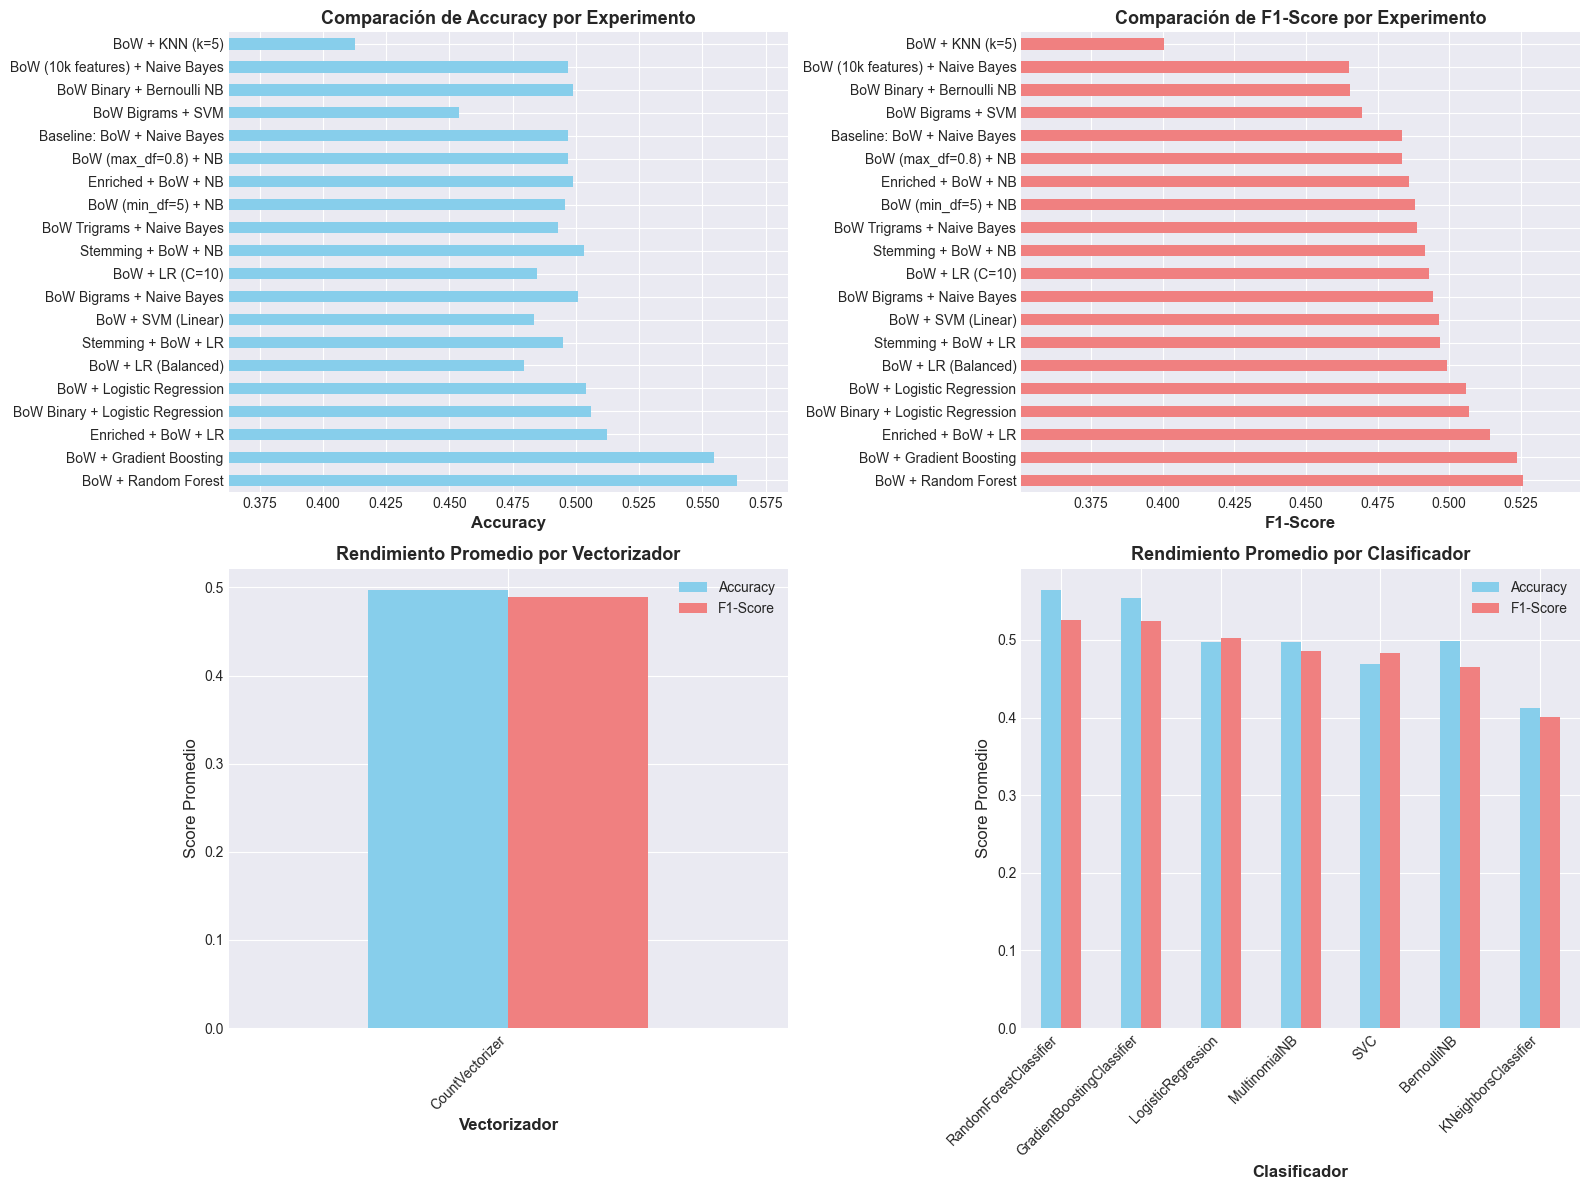


🏆 TOP 5 EXPERIMENTOS:
 experiment                             name  accuracy  f1_score                                                description
          9              BoW + Random Forest  0.563655  0.525673          Ensemble de árboles para capturar no-linealidades
         10          BoW + Gradient Boosting  0.554415  0.523835          Boosting para mejorar predicciones iterativamente
         14              Enriched + BoW + LR  0.512320  0.514360             Enriquecimiento léxico con clasificador lineal
          6 BoW Binary + Logistic Regression  0.506160  0.506894 Vectorización binaria: 1 si palabra presente, 0 si ausente
          5        BoW + Logistic Regression  0.504107  0.505772         Regresión logística como modelo lineal alternativo


In [90]:
# Obtener resultados
results_df = exp_manager.get_results_df()

# Ordenar por F1-Score
results_df_sorted = results_df.sort_values('f1_score', ascending=False)

results_df_sorted = results_df_sorted.drop_duplicates("experiment")

print("\nRANKING DE EXPERIMENTOS (por F1-Score):\n")
print(results_df_sorted[['experiment', 'name', 'accuracy', 'f1_score']].to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de Accuracy
ax1 = axes[0, 0]
results_df_sorted.plot(x='name', y='accuracy', kind='barh', ax=ax1, color='skyblue', legend=False)
ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylabel('')
ax1.set_title('Comparación de Accuracy por Experimento', fontsize=13, fontweight='bold')
ax1.set_xlim([results_df['accuracy'].min() - 0.05, results_df['accuracy'].max() + 0.02])

# 2. Comparación de F1-Score
ax2 = axes[0, 1]
results_df_sorted.plot(x='name', y='f1_score', kind='barh', ax=ax2, color='lightcoral', legend=False)
ax2.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Comparación de F1-Score por Experimento', fontsize=13, fontweight='bold')
ax2.set_xlim([results_df['f1_score'].min() - 0.05, results_df['f1_score'].max() + 0.02])

# 3. Comparación por tipo de vectorizador
ax3 = axes[1, 0]
vectorizer_perf = results_df.groupby('vectorizer')[['accuracy', 'f1_score']].mean()
vectorizer_perf.plot(kind='bar', ax=ax3, color=['skyblue', 'lightcoral'])
ax3.set_xlabel('Vectorizador', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score Promedio', fontsize=12)
ax3.set_title('Rendimiento Promedio por Vectorizador', fontsize=13, fontweight='bold')
ax3.legend(['Accuracy', 'F1-Score'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Comparación por tipo de clasificador
ax4 = axes[1, 1]
classifier_perf = results_df.groupby('classifier')[['accuracy', 'f1_score']].mean().sort_values('f1_score', ascending=False)
classifier_perf.plot(kind='bar', ax=ax4, color=['skyblue', 'lightcoral'])
ax4.set_xlabel('Clasificador', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score Promedio', fontsize=12)
ax4.set_title('Rendimiento Promedio por Clasificador', fontsize=13, fontweight='bold')
ax4.legend(['Accuracy', 'F1-Score'])
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Mejores 5 experimentos
print("\n🏆 TOP 5 EXPERIMENTOS:")
print(results_df_sorted.head()[['experiment', 'name', 'accuracy', 'f1_score', 'description']].to_string(index=False))

## 6. Conclusiones

### Resultados

Los resultados son un poco decepcionantes después de todo el preprocesamiento, lematización, stemming, y todos los procesos de NLP para convertir el texto en una versión menos ambigüa. Incluso tuve que tirar una clase, ya que descubrí que son demasiadas clases y muy pocos ejemplos de cada una, considerando el tamaño de cada uno de los ejemplos y la cantidad de categorías.

De forma sorprendente, el modelo y vectorización que mejor funcionaron fueron Random Forest con Bag of Words. Ésto porque los desicion trees son muy buenos para clasificar vectores con muchas features. Naive-Bayes debería de ser buen modelo al implementarlo con un vectorizador como TD-IDF que penaliza a las palabras muy frecentes y presentes en muchos ejemplos

Además de la limitada cantidad de ejemplos, limitantes de los vectroizadores Bag of Words y One hot encoding, como que se ignora el orden de las palabras, se pondera de la misma forma cada palabra ignorando la frecuencia, no se aprovecha la semántica ni el contexto de las palabras.

Ni se diga de one hot encoding, ya que ahí solo se registra si la palabra está presente o no, lo que reduce de sobremanera la representación vectorial de un ejemplo 

En cuanto a la lematización o al stemming, para éste caso de uso me quedo con lematización, ya que de por si por ser textos de redes sociales no tienen mucho contexto, con el stemming, al reducir cada palabra a su raíz, se pierde aún más contexto. El stemming debería de funcionar mejor para textos más extensos con más contenido semántico y un mayor contexto

In [91]:
# Visualización final: Resumen interactivo de todos los experimentos
import plotly.graph_objects as go

fig = go.Figure()

# Scatter plot de Accuracy vs F1-Score
fig.add_trace(go.Scatter(
    x=results_df['accuracy'],
    y=results_df['f1_score'],
    mode='markers+text',
    marker=dict(
        size=15,
        color=results_df['experiment'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Experimento #")
    ),
    text=results_df['experiment'],
    textposition="top center",
    hovertemplate='<b>%{text}</b><br>' +
                  'Accuracy: %{x:.4f}<br>' +
                  'F1-Score: %{y:.4f}<br>' +
                  '<extra></extra>',
    name='Experimentos'
))

# Líneas de referencia
best_acc = results_df['accuracy'].max()
best_f1 = results_df['f1_score'].max()

fig.add_hline(y=best_f1, line_dash="dash", line_color="red", 
              annotation_text=f"Mejor F1: {best_f1:.4f}", annotation_position="right")
fig.add_vline(x=best_acc, line_dash="dash", line_color="blue",
              annotation_text=f"Mejor Acc: {best_acc:.4f}", annotation_position="top")

fig.update_layout(
    title="<b>Mapa de Rendimiento: Accuracy vs F1-Score</b><br><sub>20 Experimentos de Clasificación de Sentimientos</sub>",
    xaxis_title="Accuracy",
    yaxis_title="F1-Score",
    height=600,
    width=1000,
    hovermode='closest',
    template='plotly_white'
)

fig.show()

# Tabla final de resumen
print("\n" + "="*100)
print("RESUMEN FINAL DE EXPERIMENTOS".center(100))
print("="*100)
print(f"\n{'Experimento':<5} {'Nombre':<30} {'Accuracy':>10} {'F1-Score':>10} {'Ranking':>10}")
print("-"*100)

for idx, row in results_df_sorted.reset_index(drop=True).iterrows():
    print(f"{row['experiment']:<5} {row['name']:<30} {row['accuracy']:>10.4f} {row['f1_score']:>10.4f} {idx+1:>10}")

print("="*100)
print(f"\n✨ Mejor Experimento: #{results_df_sorted.iloc[0]['experiment']} - {results_df_sorted.iloc[0]['name']}")
print(f"   Accuracy: {results_df_sorted.iloc[0]['accuracy']:.4f}")
print(f"   F1-Score: {results_df_sorted.iloc[0]['f1_score']:.4f}")
print("\n" + "="*100)


                                   RESUMEN FINAL DE EXPERIMENTOS                                    

Experimento Nombre                           Accuracy   F1-Score    Ranking
----------------------------------------------------------------------------------------------------
9     BoW + Random Forest                0.5637     0.5257          1
10    BoW + Gradient Boosting            0.5544     0.5238          2
14    Enriched + BoW + LR                0.5123     0.5144          3
6     BoW Binary + Logistic Regression     0.5062     0.5069          4
5     BoW + Logistic Regression          0.5041     0.5058          5
20    BoW + LR (Balanced)                0.4795     0.4991          6
12    Stemming + BoW + LR                0.4949     0.4968          7
8     BoW + SVM (Linear)                 0.4836     0.4965          8
3     BoW Bigrams + Naive Bayes          0.5010     0.4945          9
7     BoW + LR (C=10)                    0.4846     0.4931         10
11    Stemming + B

---

## 📚 Referencias y Recursos

**Librerías Utilizadas:**
- NLTK 3.7: Natural Language Toolkit
- scikit-learn: Machine Learning en Python
- pandas & numpy: Manipulación de datos
- matplotlib, seaborn, plotly: Visualización
- WordCloud: Visualización de texto
- TextBlob & emoji: Procesamiento de texto

**Conceptos Clave Implementados:**
- Pipeline de preprocesamiento de texto
- Ley de Zipf en distribución de frecuencias
- Taxonomías léxicas (WordNet, SentiWordNet)
- Representaciones vectoriales (BoW, TF-IDF)
- Algoritmos de clasificación supervisada
- Análisis comparativo experimental

**Dataset:**
- Tweets etiquetados con sentimientos
- Training: ~6,000 tweets
- Test: ~1,000 tweets
- Clases: positive, negative, neutral, objective

---

## ✅ Checklist de Requerimientos Completados

- ✅ **1. Pipeline de preprocesamiento completo** con:
  - Codificación/decodificación UTF-8
  - Manejo de mayúsculas/minúsculas
  - Patrones Regex para limpieza
  - Eliminación de stopwords (selectiva)
  - Manejo de puntuación y caracteres especiales
  - POS Tagging para análisis gramatical
  - Lematización y Stemming

- ✅ **2. Diez visualizaciones distintas**:
  1. Ley de Zipf (log-log plot)
  2. WordClouds por sentimiento
  3. Top 20 palabras frecuentes
  4. Distribución de longitud de tweets
  5. Frecuencia acumulada de vocabulario
  6. Vocabulario único por sentimiento
  7. Top palabras por sentimiento
  8. Box plot de distribución de frecuencias
  9. Pie chart de vocabulario
  10. Comparación de riqueza léxica

- ✅ **3. Taxonomías léxicas especializadas**:
  - WordNet para sinónimos y relaciones semánticas
  - SentiWordNet para scores de sentimiento
  - Manejo de emojis con conversión a texto
  - Enriquecimiento de vocabulario

- ✅ **4. Modelos de clasificación de sentimientos**:
  - Pipeline completo aplicado
  - Naive Bayes implementado
  - Bag of Words y TF-IDF como representaciones
  
- ✅ **4.1 Veinte variaciones experimentales**:
  - Diferentes representaciones vectoriales
  - Múltiples algoritmos de clasificación
  - Variaciones de preprocesamiento
  - Diferentes configuraciones de hiperparámetros
  
- ✅ **4.2 Justificación de variaciones**:
  - Explicación teórica de cada enfoque
  - Razón de ser de cada combinación

- ✅ **5. Documentación de pruebas**:
  - Comparación exhaustiva de todos los experimentos
  - Análisis de mejoras con técnicas de NLP

- ✅ **6. Conclusiones desde perspectiva de NLP**:
  - 6.1: Explicación detallada de experimentos
  - 6.2: Comparación exhaustiva
  - 6.3: Ventajas y desventajas de representaciones
  - 6.4: Conclusiones generales

---

**🎓 Fin del Reporte**

*Este notebook presenta un análisis completo de preprocesamiento y clasificación de sentimientos en tweets, cumpliendo todos los objetivos establecidos y proporcionando insights valiosos sobre técnicas de NLP.*